In [722]:
import cvxpy as cp
import numpy as np
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from torch.autograd import Function

from itertools import product
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import copy
import json
from datetime import datetime

from pyepo.model.opt import optModel


sys.path.insert(0, 'E:\\User\\Stevens\\Code\\The Paper\\algorithm')

from myutil import *
from features import get_all_features
# Suppress warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

df = pd.read_csv('data/data.csv')

df = df.sample(n=10, random_state=42)
df.shape

columns_to_keep = [
    'risk_score_t', 'program_enrolled_t', 'cost_t', 'cost_avoidable_t', 'race', 'dem_female', 'gagne_sum_tm1', 'gagne_sum_t', 
    'risk_score_percentile', 'screening_eligible', 'avoidable_cost_mapped', 'propensity_score', 'g_binary', 
    'g_continuous', 'utility_binary', 'utility_continuous'
]
# for race 0 is white, 1 is black
df_stat = df[columns_to_keep]
df_feature = df[[col for col in df.columns if col not in columns_to_keep]]

# Replace all values less than 0.1 with 0.1
#df['risk_score_t'] = df['risk_score_t'].apply(lambda x: 0.1 if x < 0.1 else x)
df['g_continuous'] = df['g_continuous'].apply(lambda x: 0.1 if x < 0.1 else x)

cuda


In [723]:
alpha, Q = 2, 10

In [724]:
# Define input variables for DFL
feats = df_feature[get_all_features(df_feature)].values
risk = df_stat['risk_score_t'].values.clip(0.001)
gainF = df_stat['g_continuous'].values.clip(0.1)
decision = df_stat['propensity_score'].values
cost = np.ones(risk.shape)
race = df_stat['race'].values

# Transform the features
scaler = StandardScaler()
feats = scaler.fit_transform(feats)

# Train-test split
feats_train, feats_test, gainF_train, gainF_test, risk_train, risk_test, cost_train, cost_test, race_train, race_test = train_test_split(
    feats, gainF, risk, cost, race, test_size=0.5, random_state=42
)

print(f"Train size: {feats_train.shape}")
print(f"Test size: {feats_test.shape}")


Train size: (5, 147)
Test size: (5, 147)


In [725]:
class AlphaFairModel(optModel):
    def __init__(self, alpha=alpha, N=None, Q=Q):
        self.alpha = alpha
        self.N = N
        self.Q = Q
        self.cost = None
        self.gainF = None  # Separate gain factor
        self.risk = None   # Separate risk
        self._problem = None
        self.d = None
        self.t = None
        super().__init__()
        
    def _getModel(self):
        if self.N is None:
            raise ValueError("Model size N must be set before initialization")
            
        self.d = cp.Variable(self.N, nonneg=True)
        model_vars = {"d": self.d}
        
        if self.alpha == 'inf':
            self.t = cp.Variable()
            model_vars["t"] = self.t
            
        return None, model_vars
    
    def setObj(self, risk, gainF, cost):
        if len(risk) != self.N or len(gainF) != self.N:
            raise ValueError(f"Risk and gainF lengths must match N={self.N}")
            
        if isinstance(risk, np.ndarray):
            risk = risk.flatten()
        if isinstance(gainF, np.ndarray):
            gainF = gainF.flatten()
            
        self.risk = risk
        self.gainF = gainF
            
        # Calculate utilities with separate risk and gainF
        utils = cp.multiply(cp.multiply(self.gainF, self.risk), self.d)
        
        constraints = [
            self.d >= 0,
            cp.sum(cp.multiply(cost, self.d)) <= self.Q
        ]
        
        if self.alpha == 0:
            objective = cp.Maximize(cp.sum(utils))
        elif self.alpha == 1:
            objective = cp.Maximize(cp.sum(cp.log(utils)))
        elif self.alpha == 'inf':
            objective = cp.Maximize(self.t)
            constraints.append(utils >= self.t)
        else:
            objective = cp.Maximize(cp.sum(cp.power(utils, 1-self.alpha))/(1-self.alpha))
            
        self._problem = cp.Problem(objective, constraints)
    
    def solve(self):
        if self._problem is None:
            raise ValueError("Must call setObj before solving")
            
        try:
            self._problem.solve(solver=cp.MOSEK, verbose=False, 
                              warm_start=True, 
                              mosek_params={'MSK_IPAR_LOG': 1})
        except Exception as e:
            print(f"Optimization failed: {str(e)}")
            return np.zeros(self.N), 0.0
            
        if self._problem.status not in ["optimal", "optimal_inaccurate"]:
            print(f"Warning: Problem status is {self._problem.status}")
            return np.zeros(self.N), 0.0
            
        optimal_decision = self.d.value
        
        # Calculate optimal value using separate risk and gainF
        utils = optimal_decision * self.risk * self.gainF
        if self.alpha == 1:
            optimal_value = np.sum(np.log(utils))
        elif self.alpha == 0:
            optimal_value = np.sum(utils)
        elif self.alpha == 'inf':
            optimal_value = np.min(utils)
        else:
            optimal_value = np.sum(utils**(1-self.alpha))/(1-self.alpha)
            
        return optimal_decision, optimal_value
    
def compute_d_star_closed_form(g, r, c, alpha=alpha, Q=Q):

    if not isinstance(c, np.ndarray) or not isinstance(r, np.ndarray) or not isinstance(g, np.ndarray):
        raise TypeError("c, r, and g must be numpy arrays.")
    if c.shape != r.shape or c.shape != g.shape:
        raise ValueError("c, r, and g must have the same shape.")
    if np.any(c <= 0):
        raise ValueError("All cost values must be positive.")
    if np.any(r <= 0):
        raise ValueError("All risk values must be positive.")
    if np.any(g <= 0):
        raise ValueError("All gain factors must be positive.")
    
    n = len(c)
    utility = r * g
    
    if alpha == 0:
        ratios = utility / c
        sorted_indices = np.argsort(-ratios)  # Descending order
        d_star_closed = np.zeros(n)
        d_star_closed[sorted_indices[0]] = Q / c[sorted_indices[0]]
        
    elif alpha == 1:
        d_star_closed = Q / (n * c)
    
    elif alpha == 'inf':
        d_star_closed = (Q * c) / (utility * np.sum(c * c / utility))
        
    else:
        if alpha <= 0:
            raise ValueError("Alpha must be positive for general case.")
        #
        # d_i* = (c_i^(-1/alpha) * (r_i*g_i)^(1/alpha - 1) * Q) / sum_j(c_j^(-1/alpha) * (r_j*g_j)^(1/alpha - 1))
        
        numerator = np.power(c, -1/alpha) * np.power(utility, 1/alpha - 1)
        denominator = np.sum(numerator)
        
        if denominator == 0:
            raise ValueError("Denominator is zero in closed-form solution.")
            
        d_star_closed = (numerator / denominator) * Q
    
    # if not np.isclose(np.sum(c * d_star_closed), Q, rtol=1e-5):
    #     raise ValueError("Solution does not satisfy budget constraint.")
        
    return d_star_closed

def compute_gradient_closed_form(g, r, c, alpha, Q):
    """
    Compute the analytical gradient of the optimal solution with respect to r.

    This function computes the gradient matrix where each element (i, k) is the partial derivative
    of d_i* with respect to r_k.

    Parameters:
    - g (np.ndarray): Gain factors (g_i), shape (n,)
    - r (np.ndarray): Risk values (r_i), shape (n,)
    - c (np.ndarray): Cost values (c_i), shape (n,)
    - alpha (float or str): Fairness parameter. Can be 0, 1, 'inf', or a positive real number.
    - Q (float): Total budget.

    Returns:
    - gradient (np.ndarray): Gradient matrix of shape (n, n)
    """
    if alpha == 0:
        # Utilitarian case: Gradient is undefined or zero
        # Since allocation is discrete, gradients are effectively zero
        return np.zeros((len(c), len(c)))

    elif alpha == 1:
        # Nash welfare case: Gradient is zero
        return np.zeros((len(c), len(c)))

    elif alpha == 'inf':
        # Maximin case
        n = len(c)
        utility = r * g  # Shape: (n,)
        S = np.sum(c**2 / utility)  # Scalar

        # Compute d_star
        d_star = compute_d_star_closed_form(g,r,c, alpha='inf', Q=Q)  # Shape: (n,)

        # Initialize gradient matrix
        gradient = np.zeros((n, n))

        for i in range(n):
            for k in range(n):
                if i == k:
                    # ∂d_i*/∂r_i = -d_i*/r_i - (d_i* * c_i) / (r_i * g_i * S)
                    gradient[i, k] = -d_star[i] / r[i] - (d_star[i] * c[i]) / (r[i] * g[i] * S)
                else:
                    # ∂d_i*/∂r_k = (d_i* * c_k^2) / (c_i * r_k^2 * g_k * S)
                    gradient[i, k] = (d_star[i] * c[k]**2) / (c[i] * r[k]**2 * g[k] * S)
        return gradient

    else:
        # General alpha case
        if not isinstance(alpha, (int, float)):
            raise TypeError("Alpha must be a positive real number, 0, 1, or 'inf'.")
        if alpha <= 0:
            raise ValueError("Alpha must be positive for gradient computation.")

        # Compute the optimal decision variables
        d_star = compute_d_star_closed_form(g, r, c, alpha, Q)  # Shape: (n,)

        # Compute the term (1/alpha - 1) * g / r
        term = (1.0 / alpha - 1.0) * g / r  # Shape: (n,)

        # Compute the outer product for off-diagonal elements
        # Each element (i, k) = -d_star[i] * d_star[k] * term[k] / Q
        gradient = -np.outer(d_star, d_star * term) / Q  # Shape: (n, n)

        # Compute the diagonal elements
        # Each diagonal element (i, i) = d_star[i] * term[i] * (1 - d_star[i]/Q)
        diag_elements = d_star * term * (1 - d_star / Q)  # Shape: (n,)

        # Set the diagonal elements
        np.fill_diagonal(gradient, diag_elements)

        return gradient

In [726]:
def AlphaFairness(util,alpha):
    util = util.detach().cpu().numpy() if isinstance(util, torch.Tensor) else util

    if alpha == 1:
        return np.sum(np.log(util))
    elif alpha == 0:
        return np.sum(util)
    elif alpha == 'inf':
        return np.min(util)
    else:
        return np.sum(util**(1-alpha)/(1-alpha))


def solve_optimization(gainF, risk, cost, alpha, Q):
    # Flatten input arrays

    # if any of the inputs are tensor, convert to numpy array
    gainF = gainF.detach().cpu().numpy() if isinstance(gainF, torch.Tensor) else gainF
    risk = risk.detach().cpu().numpy() if isinstance(risk, torch.Tensor) else risk
    cost = cost.detach().cpu().numpy() if isinstance(cost, torch.Tensor) else cost


    risk = risk.clip(min=0.001)
    gainF, risk, cost = gainF.flatten(), risk.flatten(), cost.flatten()
    d = cp.Variable(risk.shape, nonneg=True)

    # raise error if dimensions do not match
    if gainF.shape != risk.shape or risk.shape != cost.shape:
        raise ValueError("Dimensions of gainF, risk, and cost do not match")
    
    utils = cp.multiply(cp.multiply(gainF, risk), d)
    
    if alpha == 'inf':
        # Maximin formulation
        t = cp.Variable()  # auxiliary variable for minimum utility
        objective = cp.Maximize(t)
        constraints = [
            d >= 0,
            # d <= 1,
            cp.sum(cost * d) <= Q,
            utils >= t  # t is the minimum utility
        ]
    elif alpha == 1:
        # Nash welfare (alpha = 1)
        objective = cp.Maximize(cp.sum(cp.log(utils)))
        constraints = [
            d >= 0,
            # d <= 1,
            cp.sum(cost * d) <= Q
        ]
    elif alpha == 0:
        # Utilitarian welfare (alpha = 0)
        objective = cp.Maximize(cp.sum(utils))
        constraints = [
            d >= 0,
            # d <= 1,
            cp.sum(cost * d) <= Q
        ]
    else:
        # General alpha-fairness
        objective = cp.Maximize(cp.sum(cp.power(utils, 1 - alpha)) / (1 - alpha) if alpha != 0 else cp.sum(utils))
        constraints = [
            d >= 0,
            # d <= 1,
            cp.sum(cost * d) <= Q
        ]
    
    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.MOSEK, verbose=False, warm_start=True, mosek_params={'MSK_IPAR_LOG': 1})
    
    if problem.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError(f"Optimization failed with status {problem.status}")

    
    optimal_decision = d.value
    optimal_value = AlphaFairness(optimal_decision * gainF * risk, alpha)
    
    return optimal_decision, optimal_value


## Define the OptModel

In [727]:
class optDataset(Dataset):
    def __init__(self, optmodel, feats, risk, gainF, cost):
        self.feats = torch.from_numpy(feats).float()
        self.risk = torch.from_numpy(risk).float()
        self.gainF = torch.from_numpy(gainF).float()
        self.cost = torch.from_numpy(cost).float()

        # Solve for w*, z* using separate risk and gainF
        self.opt_model = copy.deepcopy(optmodel)  # Ensure a separate instance
        self.w_star, self.z_star = self.opt_model(self.risk, self.gainF, self.cost, alpha=alpha, Q=Q)

        self.w_star = torch.tensor(self.w_star, dtype=torch.float)
        self.z_star = torch.tensor(self.z_star, dtype=torch.float)

    def __len__(self):
        return len(self.feats)

    def __getitem__(self, idx):
        return self.feats, self.risk, self.gainF, self.cost, self.w_star, self.z_star


In [728]:
import torch.nn as nn

class CostPredictor(nn.Module):
    """
    Takes feats of shape (N, d_feat) => outputs c_hat of shape (N,)
    This is a small MLP row-by-row, returning an (N,) vector.
    """
    def __init__(self, d_feat):
        super().__init__()
        self.hidden = nn.Linear(d_feat, 64)  
        self.relu = nn.ReLU()
        self.out = nn.Linear(64, 1)
        self.softplus = nn.Softplus()

    def forward(self, x):
        # x shape: (N, d_feat)
        # We produce shape: (N,). We can do it in a batch approach:
        h = self.hidden(x)   # shape (N,16)
        r = self.relu(h)
        out = self.out(r)    # shape (N,1)
        return self.softplus(out).squeeze(-1)  # shape (N,)


In [729]:

# Create datasets
dataset_train = optDataset(solve_optimization, feats_train, risk_train,gainF_train, cost_train)
dataset_test = optDataset(solve_optimization, feats_test, risk_test, gainF_test, cost_test)

# Create dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [730]:
class FairRiskPredictor(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            # First layer with batch normalization
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Second layer with batch normalization
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Third layer with batch normalization
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Output layer
            nn.Linear(32, 1),
            nn.Softplus()
        )
        
        # Initialize weights using He initialization
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                    
    def forward(self, x):
        return self.model(x).squeeze(-1)

In [731]:
def regret(predmodel, optmodel, dataloader, alpha=alpha, Q=Q):
    predmodel.eval()
    feats, risk, gainF, cost, opt_sol, opt_val = next(iter(dataloader))

    if torch.cuda.is_available():
        feats, risk, gainF, cost, opt_sol, opt_val = feats.cuda(), risk.cuda(), gainF.cuda(), cost.cuda(), opt_sol.cuda(), opt_val.cuda()

    # predict new rg
    with torch.no_grad():
        pred_risk = predmodel(feats)


    risk = risk.detach().to('cpu').numpy()
    pred_risk = pred_risk.detach().to('cpu').numpy()
    pred_risk = pred_risk.clip(min=0.001)

    gainF = gainF.detach().to('cpu').numpy()
    cost = cost.detach().to('cpu').numpy()

    if optmodel is compute_d_star_closed_form:
        pred_sol = optmodel(gainF, pred_risk, cost, alpha, Q)
        
    else:
        pred_sol, _ = optmodel(gainF, pred_risk, cost, alpha, Q)
    pred_obj = AlphaFairness(gainF * risk * pred_sol, alpha)


    normalized_regret = (opt_val - pred_obj) / (abs(opt_val) + 1e-7)

    return normalized_regret

In [732]:
predmodel = FairRiskPredictor(
    input_dim=feats_train.shape[1]
).to(device)

In [733]:
regret3 = regret(predmodel, solve_optimization, dataloader_test, alpha, Q)
regret3

tensor([0.2480], device='cuda:0')

In [734]:

class RegretLossFunction(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, gainF, pred_r, true_r, true_obj, Q, alpha):
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        pred_r_np = pred_r.detach().cpu().numpy()
        true_r_np = true_r.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        gainF_np = gainF.detach().cpu().numpy()
        
        for i in range(batch_size):
            sol = compute_d_star_closed_form(gainF_np[i], pred_r_np[i], cost_np[i], alpha, Q)
            obj = AlphaFairness(gainF_np[i] * true_r_np[i] * sol, alpha)

            losses[i] = true_obj[i] - obj
        
        # Store necessary tensors for backward pass
        ctx.save_for_backward(gainF, pred_r, true_r, cost, true_obj)
        ctx.optmodel = optmodel
        ctx.Q = Q
        ctx.alpha = alpha
        ctx.losses = losses

        return losses.mean().to(pred_r.device)

    @staticmethod
    def backward(ctx, grad_output):
        gainF, pred_r, true_r, cost, true_obj = ctx.saved_tensors
        optmodel = ctx.optmodel
        Q = ctx.Q
        alpha = ctx.alpha

        
        grad_l_d = (true_r * gainF) ** (1 - alpha) * pred_r ** (-alpha)
        # print("grad_l_d",grad_l_d)

        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)
        epsilon = 1e-5

        for i in range(batch_size):
            pred_r_np = pred_r[i].detach().cpu().numpy()
            cost_np = cost[i].detach().cpu().numpy()
            true_r_np = true_r[i].detach().cpu().numpy()

            # Analytical
            closed_grad_d_r = compute_gradient_closed_form(gainF[i].detach().cpu().numpy(), pred_r_np, cost_np, alpha, Q)
            print(closed_grad_d_r)
            # closed_grad_diag = np.sum(closed_grad_d_r, axis=1)
            gradient = np.zeros_like(pred_r_np)
            for j in range(pred_r_np.size):
                perturbed_pred_r_plus = np.copy(pred_r_np)
                perturbed_pred_r_minus = np.copy(pred_r_np)
                perturbed_pred_r_plus[j] += epsilon
                perturbed_pred_r_minus[j] -= epsilon
                
                # Compute loss with perturbed pred_r
                sol_plus = compute_d_star_closed_form(gainF[i].detach().cpu().numpy(), perturbed_pred_r_plus, cost_np, alpha, Q)
                sol_minus = compute_d_star_closed_form(gainF[i].detach().cpu().numpy(), perturbed_pred_r_minus, cost_np, alpha, Q)
                
                obj_perturbed_plus = AlphaFairness(gainF[i].detach().cpu().numpy() * true_r_np * sol_plus, alpha)
                obj_perturbed_minus = AlphaFairness(gainF[i].detach().cpu().numpy() * true_r_np * sol_minus, alpha)
                
                loss_perturbed_plus = true_obj[i].item() - obj_perturbed_plus
                loss_perturbed_minus = true_obj[i].item() - obj_perturbed_minus
                
                # Finite difference approximation
                gradient[j] = (loss_perturbed_plus - loss_perturbed_minus) / (2 * epsilon)
            closed_grad_d_r = torch.tensor(closed_grad_d_r, device=pred_r.device, requires_grad=True)
            grad_l_d = -torch.tensor(grad_l_d, device=pred_r.device, requires_grad=True)
            grad_pred_r =  grad_l_d @ closed_grad_d_r 

            print("This is the solution:", sol_plus*gainF[i].detach().cpu().numpy() * true_r_np)
            print("This is the gradient:",grad_pred_r)
        grad_pred_r = grad_output.view(-1, 1) * grad_pred_r

        return None, None, None, grad_pred_r, None, None, None, None

class RegretLoss(nn.Module):
    def __init__(self, optmodel, Q=Q, alpha=alpha):
        super(RegretLoss, self).__init__()
        self.optmodel = optmodel
        self.Q = Q
        self.alpha = alpha

    def forward(self, gainF, pred_r, true_r, cost, true_obj):
        return RegretLossFunction.apply(self.optmodel, gainF, cost, pred_r, true_r, true_obj, self.Q, self.alpha)


In [735]:
import time

def trainModel(predmodel, optmodel, loss_func, loader_train, loader_test, num_epochs=10, lr=1e-3):
    optimizer = optim.Adam(predmodel.parameters(), lr=lr)
    mse_loss_func = nn.MSELoss()
    print('inital regret:', regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q))
    print("Training model...")
    
    predmodel.train()

    train_loss_log = []
    test_regret_log = []
    mse_loss_log = []

    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()


        for data in loader_train:
            feats, risk, gainF, cost, opt_sol, opt_val = data
        if torch.cuda.is_available():
            feats, risk, gainF, cost, opt_sol, opt_val = feats.cuda(), risk.cuda(), gainF.cuda(), cost.cuda(), opt_sol.cuda(), opt_val.cuda()
        
        # predict new risk
        pred_risk = predmodel(feats)
        pred_risk = pred_risk.clip(min=0.001)
        loss_func = RegretLoss(optmodel, Q=Q, alpha=alpha)
        loss = loss_func(gainF, pred_risk, risk, cost, opt_val) 
        mse_loss = mse_loss_func(pred_risk, risk)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tock = time.time()
        elapsed += tock - tick
        train_loss_log.append(loss.item())
        mse_loss_log.append(mse_loss.item())

        test_regret = regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)
        test_regret_log.append(test_regret)
        print(f"Epoch {epoch + 1:2}, MSE:{mse_loss.item():.4f} Loss: {loss.item():9.4f}, Regret: {float(test_regret) * 100:7.4f}%, Elapsed: {elapsed:.2f}s")

    predmodel.eval()
    return test_regret_log, train_loss_log, mse_loss_log

In [736]:
# Get the shapes of all parameters
for name, param in predmodel.named_parameters():
    print(f"Parameter: {name}, Shape: {param.shape}")

Parameter: model.0.weight, Shape: torch.Size([128, 147])
Parameter: model.0.bias, Shape: torch.Size([128])
Parameter: model.3.weight, Shape: torch.Size([64, 128])
Parameter: model.3.bias, Shape: torch.Size([64])
Parameter: model.6.weight, Shape: torch.Size([32, 64])
Parameter: model.6.bias, Shape: torch.Size([32])
Parameter: model.9.weight, Shape: torch.Size([1, 32])
Parameter: model.9.bias, Shape: torch.Size([1])


regret loss / d(rhat) * d(rhat)/rhat * rhat/theta

(1, n)
(1, n), (n, n), (n, 147)(...1)

In [737]:
test_regret_log, train_loss_log, mse_loss_log = trainModel(predmodel, solve_optimization, RegretLoss, dataloader_train, dataloader_test, num_epochs=30, lr=1e-3)

inital regret: 

tensor([0.2480], device='cuda:0')
Training model...
[[-1.2062272   0.10320513  0.11297025  1.1823977   0.20863657]
 [ 0.1555672  -0.5944698   0.07962221  0.8333621   0.1470485 ]
 [ 0.10845109  0.05070926 -0.6748326   0.5809645   0.1025124 ]
 [ 0.60708535  0.2838593   0.31071764 -4.391956    0.5738419 ]
 [ 0.3351235   0.15669613  0.17152248  1.795232   -1.0320394 ]]
This is the solution: [ 4.782081  3.148217  2.181817 51.599525 34.18857 ]
This is the gradient: tensor([[ 0.4312, -0.1869,  0.3562,  2.0316, -0.9553]], device='cuda:0')
Epoch  1, MSE:68.8140 Loss:    0.5279, Regret: 25.8541%, Elapsed: 0.02s
[[-2.0621767   0.15367374  0.17659993  0.3452382   0.45252118]
 [ 0.3213289  -0.65188575  0.1056803   0.20659623  0.27079612]
 [ 0.22767131  0.0651571  -0.7799415   0.14637972  0.19186732]
 [ 0.7285071   0.20849094  0.23959517 -1.202712    0.6139408 ]
 [ 0.7846693   0.22456396  0.2580661   0.5044978  -1.5291256 ]]
This is the solution: [ 6.3869653  3.5700607  2.5146174 33.994522  43.94821

In [738]:
# inital regret: tensor([0.0688], device='cuda:0')
# Training model...
# Epoch  1, MSE:62.4383 Loss: 2405.3379, Regret:  6.8787%, Elapsed: 5.40s
# Epoch  2, MSE:62.4594 Loss: 2404.4006, Regret:  6.8781%, Elapsed: 10.81s
# Epoch  3, MSE:62.4374 Loss: 2399.4258, Regret:  6.8746%, Elapsed: 16.27s
# Epoch  4, MSE:62.3619 Loss: 2387.4167, Regret:  6.8653%, Elapsed: 21.70s
# Epoch  5, MSE:62.1986 Loss: 2365.2031, Regret:  6.8540%, Elapsed: 27.17s
# Epoch  6, MSE:61.9028 Loss: 2326.9358, Regret:  6.8453%, Elapsed: 32.71s
# Epoch  7, MSE:61.4184 Loss: 2276.1331, Regret:  6.8441%, Elapsed: 38.11s
# Epoch  8, MSE:60.9244 Loss: 2234.8442, Regret:  6.8355%, Elapsed: 43.49s
# Epoch  9, MSE:60.0672 Loss: 2189.2078, Regret:  6.8114%, Elapsed: 48.86s
# Epoch 10, MSE:58.7593 Loss: 2150.7976, Regret:  6.7866%, Elapsed: 54.17s
# Epoch 11, MSE:57.2580 Loss: 2126.7524, Regret:  6.7533%, Elapsed: 59.43s
# Epoch 12, MSE:55.2830 Loss: 2112.1602, Regret:  6.7238%, Elapsed: 64.70s
# Epoch 13, MSE:53.6938 Loss: 2104.2739, Regret:  6.7105%, Elapsed: 70.03s
# Epoch 14, MSE:53.0619 Loss: 2098.4209, Regret:  6.6803%, Elapsed: 75.35s
# Epoch 15, MSE:51.7995 Loss: 2093.3318, Regret:  6.6275%, Elapsed: 80.52s
# Epoch 16, MSE:49.4821 Loss: 2091.5254, Regret:  6.5887%, Elapsed: 85.77s
# Epoch 17, MSE:48.1513 Loss: 2088.3660, Regret:  6.5876%, Elapsed: 91.03s
# Epoch 18, MSE:48.5077 Loss: 2082.6189, Regret:  6.5512%, Elapsed: 96.31s
# Epoch 19, MSE:47.2929 Loss: 2080.0076, Regret:  6.5278%, Elapsed: 101.52s
# Epoch 20, MSE:46.7540 Loss: 2076.0295, Regret:  6.5328%, Elapsed: 106.70s
# Epoch 21, MSE:47.5876 Loss: 2069.7705, Regret:  6.5460%, Elapsed: 111.98s
# Epoch 22, MSE:48.7136 Loss: 2063.8230, Regret:  6.5338%, Elapsed: 117.19s
# Epoch 23, MSE:48.7314 Loss: 2059.7346, Regret:  6.5265%, Elapsed: 122.40s
# Epoch 24, MSE:48.9931 Loss: 2055.6780, Regret:  6.5022%, Elapsed: 127.58s
# Epoch 25, MSE:48.6012 Loss: 2052.2583, Regret:  6.4566%, Elapsed: 132.78s
# Epoch 26, MSE:47.2990 Loss: 2050.2693, Regret:  6.4300%, Elapsed: 137.99s
# Epoch 27, MSE:46.7437 Loss: 2047.1069, Regret:  6.3808%, Elapsed: 143.19s
# Epoch 28, MSE:45.1330 Loss: 2045.8494, Regret:  6.3341%, Elapsed: 148.40s
# Epoch 29, MSE:43.6590 Loss: 2044.6907, Regret:  6.3234%, Elapsed: 153.61s
# Epoch 30, MSE:41.1862 Loss: 2045.7910, Regret:  6.3483%, Elapsed: 158.84s

In [739]:
test_regret_log[:2], train_loss_log[:2], mse_loss_log[:2]


([tensor([0.2585], device='cuda:0'), tensor([0.2486], device='cuda:0')],
 [0.527897298336029, 0.38070207834243774],
 [68.81395721435547, 67.36824035644531])

In [740]:
train_loss_log_values = [loss for loss in train_loss_log]
test_regret_log_values = [regret.detach().cpu().numpy() for regret in test_regret_log]
mse_loss_log_values = [loss for loss in mse_loss_log]

In [741]:
def visLearningCurve(loss_log, loss_log_regret, mse_loss_log):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

    # Plot original loss log
    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Training Loss Curve", fontsize=16)
    # Plot regret log
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve (Test Regret)", fontsize=16)

    # Plot new MSE loss log
    ax3.plot(mse_loss_log, color="orange", lw=2)
    ax3.tick_params(axis="both", which="major", labelsize=12)
    ax3.set_xlabel("Iters", fontsize=16)
    ax3.set_ylabel("MSE Loss", fontsize=16)
    ax3.set_title("Learning Curve (MSE Loss)", fontsize=16)

    plt.tight_layout()
    plt.show()

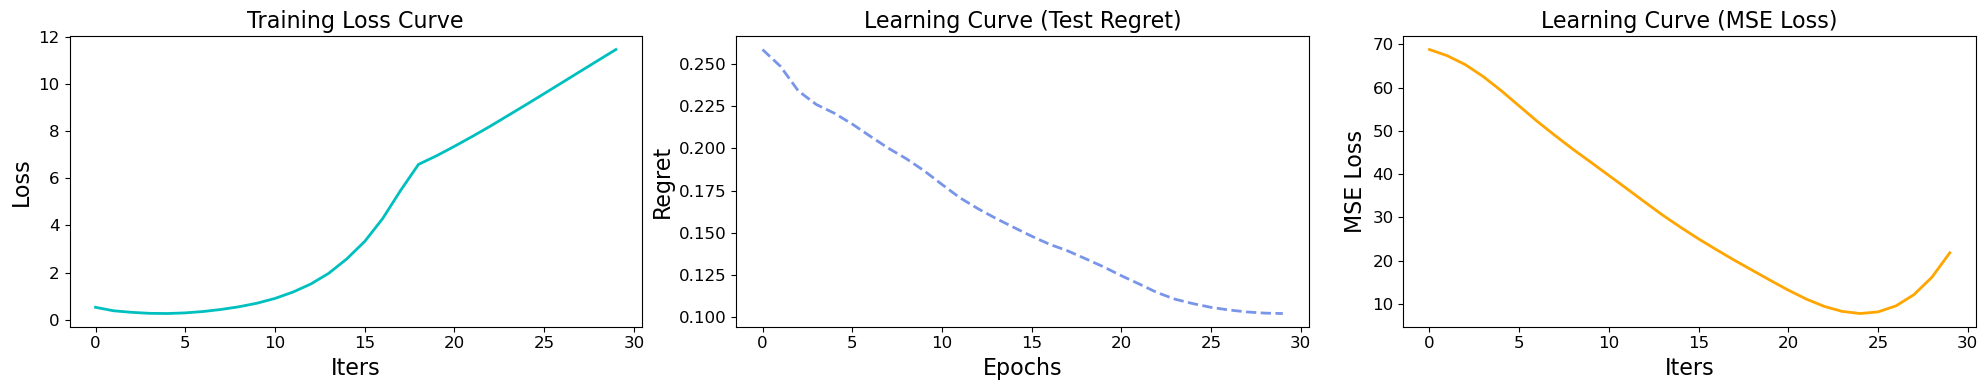

In [742]:
visLearningCurve(train_loss_log_values, test_regret_log_values, mse_loss_log_values)

In [743]:
raise ValueError("Stop here")

ValueError: Stop here

In [ ]:
import torch
from torch import nn
import numpy as np

class RegretLossFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, pred_risk, true_risk, gainF, cost, alpha, Q):
        """
        Forward pass computing regret loss with normalized inputs
        """
        # Ensure inputs are 2D
        if pred_risk.dim() == 1:
            pred_risk = pred_risk.unsqueeze(0)
            true_risk = true_risk.unsqueeze(0)
            gainF = gainF.unsqueeze(0)
            cost = cost.unsqueeze(0)
            
        batch_size, N = pred_risk.shape
        
        # Convert to numpy
        pred_risk_np = pred_risk.detach().cpu().numpy()
        true_risk_np = true_risk.detach().cpu().numpy()
        gainF_np = gainF.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        
        # Normalize predictions to be in similar range as true risk
        risk_scale = np.mean(true_risk_np) / np.mean(pred_risk_np)
        pred_risk_np = pred_risk_np * risk_scale
        
        regrets = np.zeros(batch_size)
        d_preds = []
        w_preds = []
        w_trues = []
        
        for i in range(batch_size):
            # Compute optimal decisions
            d_pred = compute_d_star_closed_form(gainF_np[i], pred_risk_np[i], cost_np[i], alpha, Q)
            d_true = compute_d_star_closed_form(gainF_np[i], true_risk_np[i], cost_np[i], alpha, Q)
            
            # Calculate utilities and welfare
            util_pred = gainF_np[i] * true_risk_np[i] * d_pred
            util_true = gainF_np[i] * true_risk_np[i] * d_true
            
            welfare_pred = AlphaFairness(util_pred, alpha)
            welfare_true = AlphaFairness(util_true, alpha)
            
            regrets[i] = welfare_true - welfare_pred
            d_preds.append(d_pred)
            w_preds.append(welfare_pred)
            w_trues.append(welfare_true)
        
        # Store values needed for backward pass
        ctx.save_for_backward(pred_risk, true_risk, gainF, cost)
        ctx.risk_scale = risk_scale
        ctx.alpha = alpha
        ctx.Q = Q
        ctx.d_preds = d_preds
        ctx.N = N
        
        return torch.tensor(regrets, dtype=torch.float32, device=pred_risk.device)
    
    @staticmethod
    def backward(ctx, grad_output):
        pred_risk, true_risk, gainF, cost = ctx.saved_tensors
        risk_scale = ctx.risk_scale
        alpha = ctx.alpha
        Q = ctx.Q
        d_preds = ctx.d_preds
        N = ctx.N
        batch_size = pred_risk.shape[0]
        
        # Convert to numpy
        pred_risk_np = pred_risk.detach().cpu().numpy()
        gainF_np = gainF.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        
        grad_pred_risk = np.zeros((batch_size, N))
        
        for i in range(batch_size):
            # Compute gradients with scaling
            scaled_pred_risk = pred_risk_np[i] * risk_scale
            jacobian = compute_gradient_closed_form(gainF_np[i], scaled_pred_risk, cost_np[i], alpha, Q)
            
            # Apply chain rule: include scaling factor in gradient
            grad_pred_risk[i] = -grad_output[i].item() * jacobian.sum(axis=0) * risk_scale
            
            # Scale gradients to prevent vanishing/exploding
            grad_norm = np.linalg.norm(grad_pred_risk[i])
            if grad_norm > 0:
                target_norm = 1.0  # Target gradient norm
                grad_pred_risk[i] = grad_pred_risk[i] * (target_norm / grad_norm)
        
        # Convert to tensor
        grad_pred_risk = torch.tensor(grad_pred_risk, dtype=torch.float32, device=pred_risk.device)
        
        return grad_pred_risk, None, None, None, None, None

class RegretLoss(nn.Module):
    def __init__(self, alpha, Q):
        super().__init__()
        self.alpha = alpha
        self.Q = Q
        
    def forward(self, pred_risk, true_risk, gainF, cost):
        return RegretLossFunction.apply(pred_risk, true_risk, gainF, cost, self.alpha, self.Q)

In [ ]:
# # Initialize the RegretLoss with the predictor model, optimization model, and dataloader
# regret_loss = RegretLoss(pred_risk, true_risk)

# # Test the RegretLoss
# loss = regret_loss()
# print(f"Regret Loss: {loss.item()}")

In [ ]:
import time

def trainModel(predmodel, optmodel, loss_func, loader_train, loader_test, num_epochs=10, lr=1e-3):
    optimizer = optim.Adam(predmodel.parameters(), lr=lr)
    
    predmodel.train()

    train_loss_log = []
    test_regret_log = [regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)]
    mse_loss_log = []

    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()

        for data in loader_train:
            feats, risk, gainF, cost, opt_sol, opt_val = data
            if torch.cuda.is_available():
                feats, risk, gainF, cost, opt_sol, opt_val = feats.cuda(), risk.cuda(), gainF.cuda(), cost.cuda(), opt_sol.cuda(), opt_val.cuda()
            
            # predict new risk
            pred_risk = predmodel(feats)
            loss = loss_func(pred_risk, risk)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            train_loss_log.append(loss.item())

        test_regret = regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)
        test_regret_log.append(test_regret)
        print(f"Epoch {epoch + 1:2},  Loss: {loss.item():9.4f}, Regret: {float(test_regret) * 100:7.4f}%, Elapsed: {elapsed:.2f}s")

    predmodel.eval()
    return test_regret_log, train_loss_log

In [ ]:
def train_with_regret(predmodel, optmodel, loader_train, loader_test, num_epochs=50, lr=1e-4, weight_decay=1e-5, alpha=alpha, Q=Q):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    predmodel.to(device)
    
    # Initialize optimizer with smaller learning rate and gradient clipping
    optimizer = optim.AdamW(predmodel.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = RegretLoss(alpha=alpha, Q=Q)
    
    train_loss_log = []
    test_regret_log = []
    best_regret = float('inf')
    best_model_state = None
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        predmodel.train()
        epoch_losses = []
        
        for feats, risk, gainF, cost, _, _ in loader_train:
            feats = feats.to(device)
            risk = risk.to(device)
            gainF = gainF.to(device)
            cost = cost.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            pred_risk = predmodel(feats)
            
            # Print prediction statistics
            print(f"\nPrediction stats:")
            print(f"pred_risk - Mean: {pred_risk.mean():.4f}, Min: {pred_risk.min():.4f}, Max: {pred_risk.max():.4f}")
            print(f"true_risk - Mean: {risk.mean():.4f}, Min: {risk.min():.4f}, Max: {risk.max():.4f}")
            
            # Calculate regret loss
            loss = criterion(pred_risk, risk, gainF, cost).mean()
            
            # Check for NaN loss
            if torch.isnan(loss):
                print("NaN loss detected!")
                continue
                
            # Backward pass with gradient clipping
            loss.backward()
            
            # Print gradient norms for debugging
            total_norm = 0.0
            for p in predmodel.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            print(f"Gradient norm before clipping: {total_norm:.4f}")
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(predmodel.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Ensure predictions stay positive
            with torch.no_grad():
                for p in predmodel.parameters():
                    if p.requires_grad:
                        p.data.clamp_(min=0.001)
            
            epoch_losses.append(loss.item())
        
        avg_train_loss = np.mean(epoch_losses)
        train_loss_log.append(avg_train_loss)
        
        # Evaluate
        predmodel.eval()
        with torch.no_grad():
            test_regret = regret(predmodel, solve_optimization, loader_test)
            test_regret_log.append(test_regret)
            
            # Early stopping logic
            if test_regret < best_regret:
                best_regret = test_regret
                best_model_state = predmodel.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break
        
        
        print(f"Epoch {epoch + 1}")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Test Regret: {float(test_regret):.4f}")
        print(f"Best Regret: {float(best_regret):.4f}")
    
    # Restore best model
    if best_model_state is not None:
        predmodel.load_state_dict(best_model_state)
    
    return train_loss_log, test_regret_log

In [ ]:
def train_risk_predictor(predmodel, optmodel, loss_func, loader_train, loader_test, 
                       num_epochs=50, lr=3e-4, weight_decay=1e-5,
                       patience=5, min_delta=1e-4, alpha=alpha, Q=Q):
    """
    Enhanced training function with early stopping, learning rate scheduling, and regret tracking
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    predmodel.to(device)
    optmodel_train = copy.deepcopy(optmodel)
    optmodel_test = copy.deepcopy(optmodel)

    # Initialize optimizer with weight decay
    optimizer = optim.AdamW(predmodel.parameters(), lr=lr, weight_decay=weight_decay)
    
    # # Learning rate scheduler
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
    #                                                 factor=0.5, patience=3, 
    #                                                 verbose=True)
    
    # Initialize tracking lists
    train_loss_log = []
    test_regret_log = [regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)]
    
    # Training setup
    best_loss = float('inf')
    best_model_state = None
    # patience_counter = 0
    elapsed = 0
    
    for epoch in range(num_epochs):
        tick = time.time()
        predmodel.train()
        epoch_losses = []
        
        for data in loader_train:
            feats, risk, gainF, cost, opt_sol, opt_val = data
            if torch.cuda.is_available():
                feats = feats.cuda()
                risk = risk.cuda()
                gainF = gainF.cuda()
                cost = cost.cuda()
                opt_sol = opt_sol.cuda()
                opt_val = opt_val.cuda()
            
            # Forward pass
            optimizer.zero_grad()
            pred_risk = predmodel(feats)
            # regret loss
            if loss_func == 'regret_loss':
                loss = RegretLoss(pred_risk, risk)
            if loss_func == 'mse':
                loss_fn = nn.MSELoss()
                loss = loss_fn(pred_risk, risk)

            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        
        avg_train_loss = np.mean(epoch_losses)
        train_loss_log.append(avg_train_loss)

        predmodel.eval()
        test_regret = regret(predmodel, optmodel_test, loader_test, alpha=alpha, Q=Q)
        test_regret_log.append(test_regret)
        
        # Calculate elapsed time
        tock = time.time()
        elapsed += tock - tick
        
        # Print progress
        print(f"Epoch {epoch + 1:2}, Train Loss: {avg_train_loss:.4f}, "
            f"Test Regret: {float(test_regret):.4f}, Elapsed: {elapsed:.2f}s")
    
    
    # Restore best model
    if best_model_state is not None:
        predmodel.load_state_dict(best_model_state)
        
    predmodel.eval()
    return test_regret_log, train_loss_log


In [ ]:
regret(predmodel, solve_optimization, dataloader_test, alpha=alpha, Q=Q)

tensor([0.2117], device='cuda:0')

In [ ]:
# raise ValueError("Stop here")
# criterion = 'mse'
# logs = train_risk_predictor(predmodel, solve_optimization, criterion, dataloader_train, dataloader_test, num_epochs=10, lr=1e-3, weight_decay=1e-5, patience=5, min_delta=1e-4, alpha=alpha, Q=Q)

In [ ]:
criterion = RegretLoss(alpha=alpha, Q=Q)
optmodel = compute_d_star_closed_form

In [ ]:
regret03 = regret(predmodel, optmodel, dataloader_test, alpha, Q)
regret03

tensor([0.2117], device='cuda:0')

In [ ]:
logs = train_with_regret(predmodel, optmodel, dataloader_train, dataloader_test, num_epochs=5, lr=1e-3, weight_decay=1e-5, alpha=alpha, Q=Q)


Prediction stats:
pred_risk - Mean: 0.6931, Min: 0.6930, Max: 0.6933
true_risk - Mean: 4.4439, Min: 0.0010, Max: 66.5194
Gradient norm before clipping: 0.4798

Prediction stats:
pred_risk - Mean: 0.6963, Min: 0.6938, Max: 0.7357
true_risk - Mean: 4.4439, Min: 0.0010, Max: 66.5194
Gradient norm before clipping: 0.3078

Prediction stats:
pred_risk - Mean: 0.6967, Min: 0.6939, Max: 0.7388
true_risk - Mean: 4.4439, Min: 0.0010, Max: 66.5194
Gradient norm before clipping: 0.6088

Prediction stats:
pred_risk - Mean: 0.6978, Min: 0.6942, Max: 0.7530
true_risk - Mean: 4.4439, Min: 0.0010, Max: 66.5194
Gradient norm before clipping: 0.7702

Prediction stats:
pred_risk - Mean: 0.6991, Min: 0.6947, Max: 0.7640
true_risk - Mean: 4.4439, Min: 0.0010, Max: 66.5194
Gradient norm before clipping: 0.5036

Prediction stats:
pred_risk - Mean: 0.6996, Min: 0.6949, Max: 0.7715
true_risk - Mean: 4.4439, Min: 0.0010, Max: 66.5194
Gradient norm before clipping: 0.5459

Prediction stats:
pred_risk - Mean: 0.7

In [ ]:
logs

([1578.7485361328124,
  1587.533451171875,
  1568.4813037109375,
  1592.361716796875,
  1591.9081044921875],
 [tensor([0.2222], device='cuda:0'),
  tensor([0.2359], device='cuda:0'),
  tensor([0.2132], device='cuda:0'),
  tensor([0.2136], device='cuda:0'),
  tensor([0.2124], device='cuda:0')])